In [2]:
import pandas as pd
import numpy as np

import scipy.sparse
import sklearn.feature_extraction

import matplotlib.pylab as plt
%matplotlib inline

from tqdm import tqdm
import platform

pd.set_option("display.max_rows", 10)
pd.set_option('display.max_columns', 1100)

import os

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
from logParser import ParseLogsFromFolder

main_data, values_data, order_data = ParseLogsFromFolder('Logs/', 0, 10, only_order=False)

main = pd.DataFrame(main_data)
del(main_data)
del(values_data)
print('Shape: ' + str(main.shape))
main.head()

  6%|▋         | 8/127 [00:06<01:54,  1.04it/s]

Shape: (185747, 3)


,User_Agent,id,ip
0,Mozilla/5.0 (Windows NT 5.1; rv:7.0.1) Gecko/2...,1487714409,87.236.194.115
1,Mozilla/5.0 (Windows NT 5.1; rv:7.0.1) Gecko/2...,1487714409,109.201.133.100
2,HybridBot (hybrid.ru/about. If our bot caused ...,1487714425,212.8.236.60
3,NaN,1487714479,192.151.150.42
4,NaN,1487714482,192.151.150.42


In [5]:
main_top_100 = main[main.User_Agent.isin(main.User_Agent.value_counts()[:100].index)]
#del(main)

top_ua = main.User_Agent.value_counts()[:100].index.tolist()

orders_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_orders = orders_vectorizer.fit_transform(order_data).astype(np.int8)
del(order_data)

## Dummy Features Preparation

In [6]:
sparse_orders_top_100 = sparse_orders[main_top_100.index]
from itertools import combinations

pairs_dict_list = []
for row_index in tqdm(range(sparse_orders_top_100.shape[0]), mininterval=2):
    pairs_dict = {}
    for pair_first, pair_second in combinations(sparse_orders_top_100[row_index].indices, 2):
        name_first = orders_vectorizer.feature_names_[pair_first]
        name_second = orders_vectorizer.feature_names_[pair_second]
        if sparse_orders_top_100[row_index, pair_first] < sparse_orders_top_100[row_index, pair_second]:
            pairs_dict['{0} < {1}'.format(name_first, name_second)] = 1
        else:
            pairs_dict['{0} < {1}'.format(name_second, name_first)] = 1
    pairs_dict_list.append(pairs_dict)

100%|██████████| 113512/113512 [03:44<00:00, 504.74it/s]


In [1]:
dummy_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_dummy = dummy_vectorizer.fit_transform(pairs_dict_list).astype(np.int8)
print(type(sparse_dummy))
print('Sparse dummy shape: \n{0}'.format(sparse_dummy.shape))
print('User Agent shape: \n{0}'.format(main_top_100.User_Agent.shape))

NameError: name 'sklearn' is not defined

## TF-IDF Features Preparation

In [11]:
tf_idf_vectorizer = sklearn.feature_extraction.text.TfidfTransformer()
tf_idf = tf_idf_vectorizer.fit_transform(sparse_dummy)
print(tf_idf.shape)
print(type(tf_idf))

(113512, 780)
<class 'scipy.sparse.csr.csr_matrix'>


## Merged Features

In [23]:
from scipy.sparse import hstack
merged = hstack((sparse_dummy, tf_idf)).tocsr()

In [24]:
print('Sparse dummy: \n{0}'.format(sparse_dummy[:1]))
print('Sparse tf-idf: \n{0}'.format(tf_idf[:1]))
print('Merged: \n{0}'.format(merged[:1]))

Sparse dummy: 
  (0, 0)	1
  (0, 64)	1
  (0, 65)	1
  (0, 66)	1
  (0, 116)	1
  (0, 117)	1
Sparse tf-idf: 
  (0, 117)	0.475177018993
  (0, 116)	0.418039527723
  (0, 66)	0.254858386256
  (0, 65)	0.474763342134
  (0, 64)	0.301955604503
  (0, 0)	0.466818528673
Merged: 
  (0, 0)	1.0
  (0, 64)	1.0
  (0, 65)	1.0
  (0, 66)	1.0
  (0, 116)	1.0
  (0, 117)	1.0
  (0, 780)	0.466818528673
  (0, 844)	0.301955604503
  (0, 845)	0.474763342134
  (0, 846)	0.254858386256
  (0, 896)	0.418039527723
  (0, 897)	0.475177018993


## Build cross-val predictions and comparison

In [15]:
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(top_ua)
y = lb.transform(main_top_100.User_Agent)
y.shape

(113512, 100)

In [157]:
cb_clf.estimator.get_params()

{'auto_stop_pval': 0,
 'depth': 6,
 'feature_border_type': 'MinEntropy',
 'has_time': False,
 'iterations': 100,
 'l2_leaf_reg': 3,
 'learning_rate': 0.03,
 'loss_function': 'Logloss',
 'name': 'experiment',
 'random_strength': 1,
 'rsm': 1,
 'store_all_simple_ctr': False,
 'use_best_model': False,
 'verbose': False}

In [161]:
from catboost import CatBoostClassifier
cb_clf = OneVsRestClassifier(CatBoostClassifier(iterations=10, depth=3, learning_rate=1))
print(cb_clf.estimator.get_params())
%time y_hat_dummy = cross_val_predict(cb_clf, sparse_dummy.toarray(), y, method='predict_proba')

{'name': 'experiment', 'random_strength': 1, 'has_time': False, 'store_all_simple_ctr': False, 'verbose': False, 'use_best_model': False, 'auto_stop_pval': 0, 'feature_border_type': 'MinEntropy', 'loss_function': 'Logloss', 'rsm': 1, 'l2_leaf_reg': 3, 'depth': 3, 'learning_rate': 1, 'iterations': 10}
CPU times: user 3h 19min 48s, sys: 4min 36s, total: 3h 24min 24s
Wall time: 1h 33min 5s


In [164]:
print(thresholded_score(0.0083, y, y_hat_dummy),  mean_answers(0.0083, y_hat_dummy))
print(thresholded_score(0.0083, y, y_hat_tf_idf), mean_answers(0.0083, y_hat_tf_idf))

0.7796532525195574 7.60654380154
0.9474416801747833 7.95218126718


In [17]:
clf = OneVsRestClassifier(LogisticRegression(C=100))
%time y_hat_dummy = cross_val_predict(clf, sparse_dummy, y, method='predict_proba', n_jobs=-1)

tf_clf = OneVsRestClassifier(LogisticRegression(C=100))
%time y_hat_tf_idf = cross_val_predict(tf_clf, tf_idf, y, method='predict_proba', n_jobs=-1)

CPU times: user 1.66 s, sys: 591 ms, total: 2.26 s
Wall time: 2min 25s
CPU times: user 1.57 s, sys: 745 ms, total: 2.32 s
Wall time: 1min 36s


In [25]:
merged_clf = OneVsRestClassifier(LogisticRegression(C=100))
%time y_hat_merged = cross_val_predict(merged_clf, merged, y, method='predict_proba', n_jobs=-1)

CPU times: user 2.02 s, sys: 1.01 s, total: 3.03 s
Wall time: 3min 49s


In [107]:
def get_f1_score(alpha, y, y_hat):
    return f1_score(y, (y_hat > alpha).astype('int'), average='samples')

def mean_answers(alpha, y_cross_val):
    return np.mean([len(list(filter(lambda i: i>alpha, y_obs))) for y_obs in y_cross_val])

def thresholded_score(alpha, y, y_cross_val):
    """
    :param alpha: Threshold
    :param y: y sample
    :param y_cross_val: y from cross_val_predict
    :return: true if at least one predicted User Agent equal true User Agent
    """
    correct_answers = 0
    for y_index, y_label in enumerate(np.argmax(y, axis=1)):
        if y_label in np.argwhere(y_cross_val[y_index] > alpha):
            correct_answers += 1

    return correct_answers / len(y)

In [26]:
threshold_grid = np.linspace(0, 0.5, 51)
dummy_f1 = [get_f1_score(alpha, y, y_hat_dummy) for alpha in tqdm(threshold_grid)]
tf_idf_f1 = [get_f1_score(alpha, y, y_hat_tf_idf) for alpha in tqdm(threshold_grid)]
merged_f1 = [get_f1_score(alpha, y, y_hat_merged) for alpha in tqdm(threshold_grid)]

100%|██████████| 51/51 [00:49<00:00,  1.06it/s]


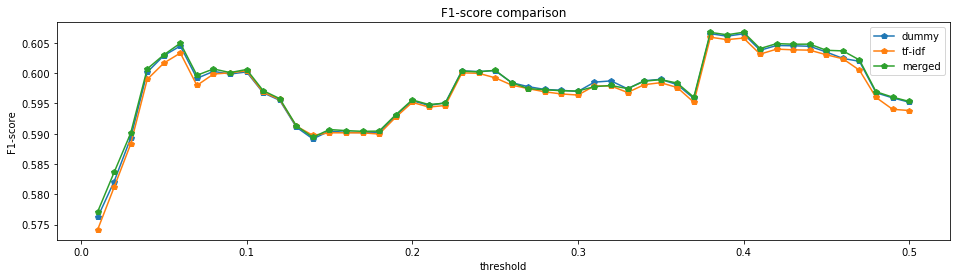

In [29]:
plt.figure(figsize=(16,4))
plt.plot(threshold_grid[1:], dummy_f1[1:], '-p', label='dummy')
plt.plot(threshold_grid[1:], tf_idf_f1[1:], '-p', label='tf-idf')
plt.plot(threshold_grid[1:], merged_f1[1:], '-p', label='merged')
plt.title('F1-score comparison')
plt.ylabel('F1-score')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [52]:
print(thresholded_score(0.0083, y, y_hat_tf_idf), mean_answers(0.0083, y_hat_tf_idf))
print(thresholded_score(0.08, y, y_hat_tf_idf), mean_answers(0.08, y_hat_tf_idf))
print(thresholded_score(0.5, y, y_hat_tf_idf), mean_answers(0.5, y_hat_tf_idf))

0.9474416801747833 7.95218126718
0.7394196208330397 1.76797166819
0.5939548241595602 0.716488124604


In [31]:
threshold_grid = np.linspace(0, 0.4, 41)
dummy_threshold_score = [thresholded_score(alpha, y, y_hat_dummy) for alpha in tqdm(threshold_grid)]
tf_idf_threshold_score = [thresholded_score(alpha, y, y_hat_tf_idf) for alpha in tqdm(threshold_grid)]
merged_threshold_score = [thresholded_score(alpha, y, y_hat_merged) for alpha in tqdm(threshold_grid)]

100%|██████████| 41/41 [02:54<00:00,  4.28s/it]


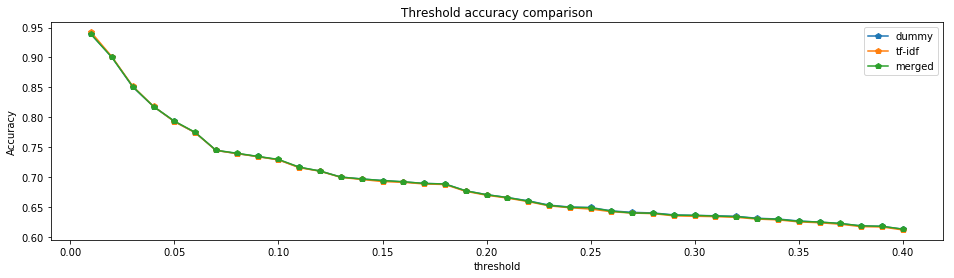

In [32]:
plt.figure(figsize=(16,4))
plt.plot(threshold_grid[1:], dummy_threshold_score[1:], '-p', label='dummy')
plt.plot(threshold_grid[1:], tf_idf_threshold_score[1:], '-p', label='tf-idf')
plt.plot(threshold_grid[1:], merged_threshold_score[1:], '-p', label='merged')

plt.title('Threshold accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [108]:
threshold_grid = np.linspace(0, 0.4, 41)
dummy_mean_answers = [mean_answers(alpha, y_hat_dummy) for alpha in tqdm(threshold_grid)]
tf_idf_mean_answers = [mean_answers(alpha, y_hat_tf_idf) for alpha in tqdm(threshold_grid)]
merged_mean_answers = [mean_answers(alpha, y_hat_merged) for alpha in tqdm(threshold_grid)]

100%|██████████| 41/41 [02:22<00:00,  3.41s/it]


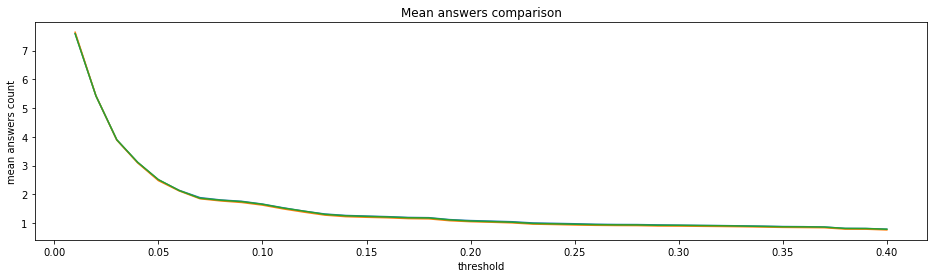

In [109]:
plt.figure(figsize=(16,4))
plt.plot(threshold_grid[1:], dummy_mean_answers[1:], label='dummy')
plt.plot(threshold_grid[1:], tf_idf_mean_answers[1:], label='dummy')
plt.plot(threshold_grid[1:], merged_mean_answers[1:], label='dummy')
plt.title('Mean answers comparison')
plt.xlabel('threshold')
plt.ylabel('mean answers count')
plt.show()

In [111]:
t = 0.1
print(thresholded_score(t, y, y_hat_tf_idf), mean_answers(t, y_hat_tf_idf))
print(thresholded_score(t, y, y_hat_dummy), mean_answers(t, y_hat_dummy))
print(thresholded_score(t, y, y_hat_merged), mean_answers(t, y_hat_merged))

0.7288920995137078 1.62241877511
0.7291740080343928 1.65876735499
0.7296585383043203 1.65103248996


In [112]:
t = 0.0083
print(thresholded_score(t, y, y_hat_tf_idf), mean_answers(t, y_hat_tf_idf))
print(thresholded_score(t, y, y_hat_dummy), mean_answers(t, y_hat_dummy))
print(thresholded_score(t, y, y_hat_merged), mean_answers(t, y_hat_merged))

0.9474416801747833 7.95218126718
0.9439706815138488 7.87966030023
0.9438385368947776 7.87765170202


## PCA

In [115]:
tf_idf.shape

(113512, 780)

In [116]:
tf_idf_dense = tf_idf.todense()

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_tf_idf = pca.fit_transform(tf_idf_dense)
pca_tf_idf.shape

(113512, 20)

In [119]:
pca_clf = OneVsRestClassifier(LogisticRegression(C=100))
%time y_hat_pca = cross_val_predict(pca_clf, pca_tf_idf, y, method='predict_proba', n_jobs=-1)

CPU times: user 1.69 s, sys: 943 ms, total: 2.63 s
Wall time: 1min 54s


In [120]:
t = 0.1
print(thresholded_score(t, y, y_hat_pca), mean_answers(t, y_hat_pca))

0.6986838395940518 1.61700084573


In [121]:
print (get_f1_score(alpha=t, y=y, y_hat=y_hat_pca))

0.568087368149


In [123]:
merged_pca = hstack((sparse_dummy, pca_tf_idf)).tocsr()
merged_pca_clf = OneVsRestClassifier(LogisticRegression(C=100))
%time y_hat_merged_pca = cross_val_predict(merged_pca_clf, merged_pca, y, method='predict_proba', n_jobs=-1)

CPU times: user 2.46 s, sys: 1.46 s, total: 3.92 s
Wall time: 4min 54s


In [126]:
t = 0.1
print(thresholded_score(t, y, y_hat_tf_idf), mean_answers(t, y_hat_tf_idf))
print(thresholded_score(t, y, y_hat_dummy), mean_answers(t, y_hat_dummy))
print(thresholded_score(t, y, y_hat_merged), mean_answers(t, y_hat_merged))
print(thresholded_score(t, y, y_hat_merged_pca), mean_answers(t, y_hat_merged_pca))

0.7288920995137078 1.62241877511
0.7291740080343928 1.65876735499
0.7296585383043203 1.65103248996
0.729200436958207 1.65178130947


In [125]:
t = 0.0083
print(thresholded_score(t, y, y_hat_tf_idf), mean_answers(t, y_hat_tf_idf))
print(thresholded_score(t, y, y_hat_dummy), mean_answers(t, y_hat_dummy))
print(thresholded_score(t, y, y_hat_merged), mean_answers(t, y_hat_merged))
print(thresholded_score(t, y, y_hat_merged_pca), mean_answers(t, y_hat_merged_pca))

0.9474416801747833 7.95218126718
0.9439706815138488 7.87966030023
0.9438385368947776 7.87765170202
0.9440059200789344 7.87695574036


## Naive Bayes

In [131]:
type(merged_pca)

scipy.sparse.csr.csr_matrix

In [132]:
print(merged_pca[:1])

  (0, 0)	1.0
  (0, 64)	1.0
  (0, 65)	1.0
  (0, 66)	1.0
  (0, 116)	1.0
  (0, 117)	1.0
  (0, 780)	-0.23797751544
  (0, 781)	0.174043103131
  (0, 782)	0.254797741096
  (0, 783)	0.838218646493
  (0, 784)	-0.0710474229814
  (0, 785)	-0.202299420578
  (0, 786)	0.0292785051366
  (0, 787)	-0.00432150488822
  (0, 788)	0.0471003796121
  (0, 789)	-0.00823344779755
  (0, 790)	0.0170656973588
  (0, 791)	-0.026728284163
  (0, 792)	0.0417455515195
  (0, 793)	-0.00838017885207
  (0, 794)	-0.00620228531239
  (0, 795)	-0.0309038500595
  (0, 796)	-0.00752583920674
  (0, 797)	0.0146896647993
  (0, 798)	-0.0300231066202
  (0, 799)	0.00495671365444


In [ ]:
from sklearn.naive_bayes import GaussianNB
gaussian_clf = OneVsRestClassifier(GaussianNB())
cross_val_predict(gaussian_clf, data_view, y, method='predict_proba', n_jobs=-1)

In [135]:
from sklearn.naive_bayes import MultinomialNB
bayes_clf = OneVsRestClassifier(MultinomialNB())
data = {'dummy': sparse_dummy,
        'tf-idf': tf_idf,
        'merged': merged,
#         'merged_pca': merged_pca
       }

clf_labels = {}
for data_name, data_view in data.items():
    print(data_name)
    %time clf_labels[data_name] = cross_val_predict(bayes_clf, data_view, y, method='predict_proba', n_jobs=-1)

dummy
CPU times: user 1.36 s, sys: 875 ms, total: 2.23 s
Wall time: 7.18 s
tf-idf
CPU times: user 1.46 s, sys: 876 ms, total: 2.34 s
Wall time: 7.69 s
merged
CPU times: user 1.54 s, sys: 857 ms, total: 2.39 s
Wall time: 8.95 s


In [137]:
t = 0.0083
for name, res in clf_labels.items():
    print(name, thresholded_score(t, y, res), mean_answers(t, res))

dummy 0.9310381281274227 12.8112005779
tf-idf 0.8770526464162379 10.7037758122
merged 0.9338572133342731 12.7134487984


In [ ]:
from sklearn.naive_bayes import GaussianNB
gauss_clf = OneVsRestClassifier(GaussianNB())
data = {'dummy': sparse_dummy,
        'tf-idf': tf_idf,
        'merged': merged,
#         'merged_pca': merged_pca
       }

clf_labels = {}
for data_name, data_view in data.items():
    print(data_name)
    %time clf_labels[data_name] = cross_val_predict(gauss_clf, data_view.toarray(), y, method='predict_proba', n_jobs=-1)

dummy
CPU times: user 2.67 s, sys: 1.27 s, total: 3.94 s
Wall time: 5min 3s
tf-idf
CPU times: user 7.61 s, sys: 2.65 s, total: 10.3 s
Wall time: 4min 53s
merged


## Blending